In [1]:
using DifferentialEquations
using Plots; pyplot()

Plots.PyPlotBackend()

In [2]:
function msd_sys(du,u,p,t)
  # Manual implementation of state transition matrix
  du[1] = u[2]
  du[2] = -p[1]*u[1] - p[2]*u[2]
  
  # Add acceleration due to gravity
  du[2] += p[3]
    
  # Add disturbance in the force
  du[2] +=  p[4]*sin(p[5]*t)
    
  # Add control input
  du[2] += p[6]
end

msd_sys (generic function with 1 method)

In [3]:
g = 9.8 # gravity in metres per second per second
mass = 0.1
k_s = 2.5 # spring constant
k_d = 0.1 # damping coefficient

u0 = [-1., 0.]

f_smc = 10.0

p_simple = [k_s/mass, k_d/mass, g, 0, 0, 0]
p_dist = [k_s/mass, k_d/mass, g, 5., 10., 0]
p_smc = [k_s/mass, k_d/mass, g, 5., 10., 0.]

tspan = (0.0,10.0)

(0.0, 10.0)

In [4]:
function smc_affect!(msd_ss_model)
    sigma = 20.0*msd_ss_model.u[1] + 1.0*msd_ss_model.u[2]
    if sigma < 0
        msd_ss_model.p[6] = +f_smc/mass
    else
        msd_ss_model.p[6] = -f_smc/mass
    end
end
pcb = PeriodicCallback(smc_affect!, 10/10000)

DiffEqBase.DiscreteCallback{DiffEqCallbacks.##40#43{Base.RefValue{Float64}},DiffEqCallbacks.##41#44{#smc_affect!,Float64,Base.RefValue{Float64}},DiffEqCallbacks.##42#45{DiffEqBase.#INITIALIZE_DEFAULT,Bool,Float64,Base.RefValue{Float64},DiffEqCallbacks.##41#44{#smc_affect!,Float64,Base.RefValue{Float64}}}}(DiffEqCallbacks.#40, DiffEqCallbacks.#41, DiffEqCallbacks.#42, (true, true))

In [5]:
prob_simple = ODEProblem(msd_sys,u0,tspan,p_simple)
prob_dist = ODEProblem(msd_sys,u0,tspan,p_dist)
prob_smc = ODEProblem(msd_sys,u0,tspan,p_smc)

DiffEqBase.ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [-1.0, 0.0]

In [6]:
@elapsed begin
    raw_sol = solve(prob_simple,Tsit5());
    dist_sol = solve(prob_dist,Tsit5());
    smc_sol = solve(prob_smc,Tsit5(),callback=pcb);
end

5.265246814

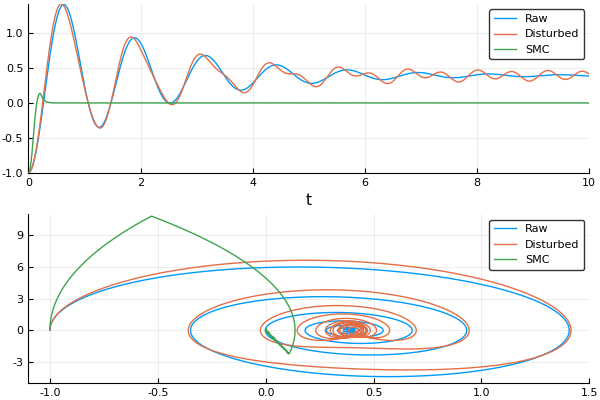

In [7]:
plot(raw_sol,vars=(0,1),w=1,label="Raw", layout = (2,1), subplot=1)
plot!(dist_sol,vars=(0,1),w=1,label="Disturbed")
plot!(smc_sol,vars=(0,1),w=1,label="SMC")
plot!(raw_sol,vars=(1,2),w=1,label="Raw",subplot=2)
plot!(dist_sol,vars=(1,2),w=1,label="Disturbed",subplot=2)
plot!(smc_sol,vars=(1,2),w=1,label="SMC",subplot=2,xlim=(-1.1,+1.5),ylim=(-5,11))